In [16]:
from pr2_utils import *
from icp_warm_up.utils import icp_partial
import gtsam
from gtsam import NonlinearFactorGraph, Values, Pose2, BetweenFactorPose2


In [17]:
dataset = 20

with np.load(f"../data/odometry_icp_{dataset}.npz") as data:
    icp_odometry_raw = data["X"]
    icp_odometry_stamp = data["stamps"]

with np.load(f"../data/odometry_imu_{dataset}.npz") as data:
    imu_odometry_raw = data["X"]
    imu_odometry_stamp = data["stamps"]

with np.load(f"../data/Hokuyo{dataset}.npz") as data:
    lidar_ranges = data["ranges"].T       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans


f_imu_odometry = InterpN1D(imu_odometry_stamp, imu_odometry_raw)
f_icp_odometry = InterpN1D(icp_odometry_stamp, icp_odometry_raw)

# using icp stamp as key
time_stamp = lidar_stamps
icp_odometry = f_icp_odometry(time_stamp)
imu_odometry = f_imu_odometry(time_stamp)

In [18]:
# graph = NonlinearFactorGraph()

# initial_estimate = Values()
# initial_estimate.insert(P(0), Pose2(0, 0, 0))
# initial_estimate.insert(P(1), Pose2(1, 0, 0))
# initial_estimate.insert(P(2), Pose2(1, 1, 0))
# initial_estimate.insert(P(3), Pose2(1, 1, 1))


# # Add a prior for the first pose, assuming we start at the origin with no uncertainty
# graph.add(gtsam.PriorFactorPose2(P(0), Pose2(0, 0, 0), gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1])))
# noise = gtsam.noiseModel.Diagonal.Sigmas([0, 0, 0])
# graph.add(BetweenFactorPose2(P(0), P(1), Pose2(2,0,0), noise))
# graph.add(BetweenFactorPose2(P(1), P(2), Pose2(0,2,0), noise))
# graph.add(BetweenFactorPose2(P(2), P(3), Pose2(0,0,2), noise))

In [19]:
def find_near_points(odometry, odo_index,
                     distance_threshold=0.1, theta_threshold=np.pi,
                     min_interval = 30):
    '''
    Given a serious of odometries and an index of interest odometry
    return a set of indices that are close to the the index.
    '''
    # Extract the point of interest
    odo_point = odometry[odo_index]

    # Calculate the distances and angles to all other points
    deltas = odometry - odo_point
    distances = deltas[:, 0]**2 + deltas[:, 1]**2
    angle_differences = np.abs((deltas[:, 2] + np.pi) % (2 * np.pi) - np.pi)

    # Find points that meet the distance and angle criteria
    close_indices = np.where((distances <= distance_threshold**2) & 
                             (angle_differences <= theta_threshold))[0]

    # Filter out points that are too close to each other in terms of index
    filtered_indices = []
    for index in close_indices:
        if not filtered_indices or (index - filtered_indices[-1]) >= min_interval:
            filtered_indices.append(index)

    return filtered_indices

find_near_points(icp_odometry, 1920)

[1916]

In [20]:
graph = NonlinearFactorGraph()

initial_estimate = Values()
for i, t in enumerate(time_stamp):
    # initial_estimate.insert(i, Pose2(0,0,0))
    initial_estimate.insert(i, Pose2(*imu_odometry_raw[i]))

# Add a prior for the first pose, assuming we start at the origin with no uncertainty
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(0, 0, 0),  gtsam.noiseModel.Diagonal.Sigmas([0, 0, 0])))


avg_error = 0.1
noise = gtsam.noiseModel.Diagonal.Sigmas([avg_error, avg_error, avg_error])

for i in range(1, time_stamp.shape[0]):
    delta_pose = icp_odometry[i, :]-icp_odometry[i-1, :]
    # print(delta_pose.shape)
    graph.add(BetweenFactorPose2(
        i-1, i, 
        Pose2(delta_pose[0], delta_pose[1], delta_pose[2]), 
        noise
    ))
# for i in range(1, time_stamp.shape[0]):
#     graph.add(BetweenFactorPose2(
#         i-1, i, 
#         Pose2(*(imu_odometry_raw[i]-imu_odometry_raw[i-1])), 
#         noise
#     ))  

            
num_new_edge = 0
sum_error = 0
bar = tqdm(range(1,time_stamp.shape[0], 10))
for i in bar:
    near_point_indices = find_near_points(icp_odometry, i)
    num_new_edge += len(near_point_indices)
    bar.set_postfix_str(f"num_new_edge: {num_new_edge}")
    for near_point_index in near_point_indices:
        T_guess = diff_transformation(
            odometry_to_transformation(imu_odometry[i]),
            odometry_to_transformation(imu_odometry[near_point_index])
        )
        delta_theta = abs( (imu_odometry[i,2]-imu_odometry[near_point_index,2]) % (2 * np.pi) - np.pi)
        expected_percentile = -0.1591*delta_theta+0.9
        T_diff, error = icp_partial(
            lidar_scan_to_3dpc(lidar_ranges[i,:]),
            lidar_scan_to_3dpc(lidar_ranges[near_point_index, :]),
            T_guess, percentile=expected_percentile
        )
        sum_error += error
        odo_diff = transformation_to_odometry(T_diff)
        graph.add(BetweenFactorPose2(
             near_point_index, i,
            Pose2(*odo_diff), 
            gtsam.noiseModel.Diagonal.Sigmas([error, error, error]))
        )
avg_error = sum_error/num_new_edge
print(avg_error)
print(num_new_edge)



  0%|          | 0/497 [00:00<?, ?it/s, num_new_edge: 15]

100%|██████████| 497/497 [00:28<00:00, 17.14it/s, num_new_edge: 1776]

0.16370766237463694
1776


In [21]:
# params = gtsam.GaussNewtonParams()
# params.setVerbosity("Termination")  # this will show info about stopping conds
# params.setMaxIterations(1500)
# optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, params)
# result = optimizer.optimize()


params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("Termination")
params.setMaxIterations(1500)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

converged
errorThreshold: 29899.3970273 <? 0
absoluteDecrease: 0.00973358825649 <? 1e-05
relativeDecrease: 3.25544527834e-07 <? 1e-05
iterations: 18 >? 1500


In [22]:
factor_graph_optimized = []
for i in range(time_stamp.shape[0]):
    pose = result.atPose2(i)
    factor_graph_optimized.append([pose.x(), pose.y(), pose.theta()])
factor_graph_optimized = np.array(factor_graph_optimized)

In [23]:
# np.savez(f'../data/odometry_lc_{dataset}_{num_new_edge}.npz', X=factor_graph_optimized, stamps=time_stamp)
# with np.load(f"../data/odometry_icp_{dataset}.npz") as data:
#     factor_graph_optimized = data["X"]
#     time_stamp = data["stamps"]

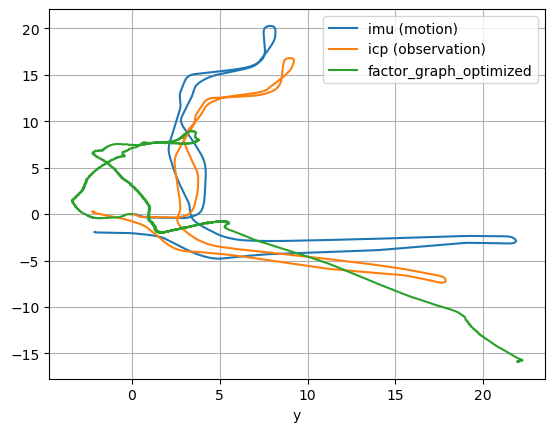

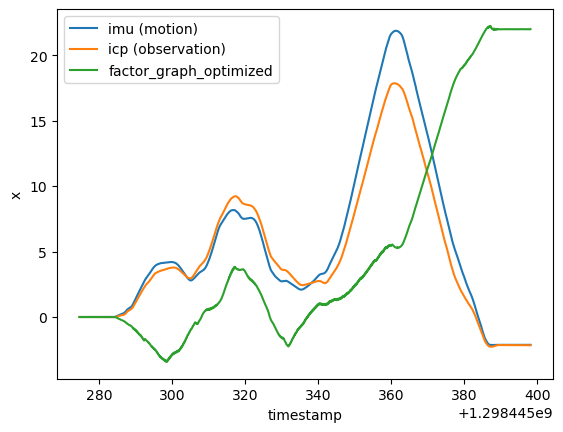

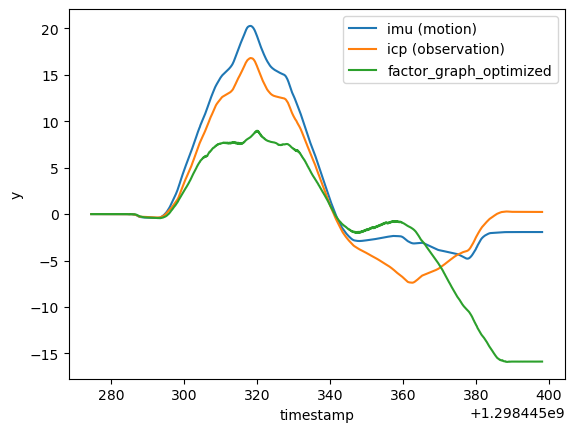

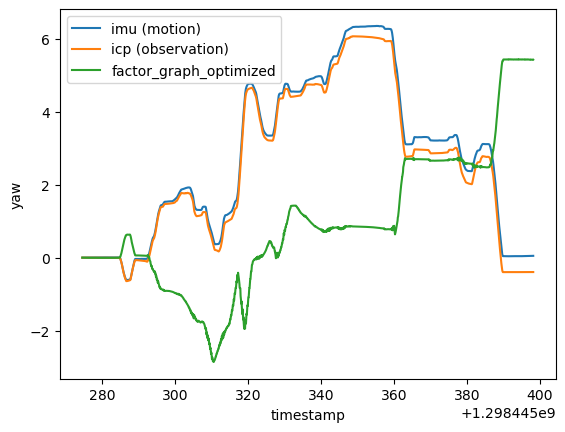

In [24]:
plot_odometry([
    (imu_odometry, time_stamp, "imu (motion)"),
    (icp_odometry, time_stamp, "icp (observation)"),
    (factor_graph_optimized, time_stamp, "factor_graph_optimized", {"linestyle":'-'})
])

In [25]:
import gtsam
import numpy as np

# Create a factor graph
graph = gtsam.NonlinearFactorGraph()

# Add a prior on the first pose, setting it to the origin
# Assume we have some noise model for the prior
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1])) # Assuming 2D: x, y, orientation
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), prior_noise))

# Add a relative measurement factor between pose 1 and pose 2
# Also assume we have a noise model for this measurement
odom_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1])) # Again, assuming 2D
graph.add(gtsam.BetweenFactorPose2(1, 2, gtsam.Pose2(2, 0, 0), odom_noise))

# Create an initial estimate for the poses
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.1))

# Optimize the graph using Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("Termination")  # this will show info about stopping conds
params.setMaxIterations(1500)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
result = optimizer.optimize()

# Print the optimized poses
print("Optimized Pose 1:", result.atPose2(1))
print("Optimized Pose 2:", result.atPose2(2))


Optimized Pose 1: (1.16244567466e-16, -6.55335308541e-17, -1.1306081112e-17)

Optimized Pose 2: (2, -1.07983550258e-16, -1.17713580057e-17)

